# PyTorch DataLoaders with Inference-Time Denoising

## 🎯 What We'll Cover

In this notebook, we'll dive deep into PyTorch's data loading components and show you a real scenario where **custom preprocessing** makes a huge difference. We'll work with electrical transformer data and implement:

1. **Standard Dataset Approach** - The typical way most tutorials show
2. **The Noise Problem** - Why raw sensor data needs special handling
3. **Custom Dataset with Conditional Denoising** - Same training data, cleaner inference
4. **Side-by-Side Comparison** - See the difference in action
5. **Complete Workflow** - Training on noisy data, inference on clean data

**Key Insight**: Train your model on realistic noisy data for robustness, but denoise inputs at inference time for better predictions!

![Alt text](pytorch-dataloading.png "PyTorch DataLoading")

In [1]:
# Core PyTorch imports for data loading
from torch.utils.data import DataLoader, Dataset  # The two main PyTorch data components
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from typing import Tuple, Optional

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device available:", "CUDA" if torch.cuda.is_available() else "CPU")


PyTorch version: 2.2.2
Device available: CPU


In [2]:
def load_electrical_data(n_samples: int = 10000, noise_level: float = 0.1) -> np.ndarray:
    """
    Generate synthetic electrical transformer data (similar to ETT dataset)
    This simulates real electrical consumption patterns with noise
    
    Args:
        n_samples: Number of time points to generate
        noise_level: Amount of noise to add (0.0 = no noise, 0.3 = high noise)
    
    Returns:
        1D numpy array of electrical consumption values
    """
    # Create time axis
    t = np.linspace(0, 100, n_samples)
    
    # Base electrical consumption pattern
    # - Daily cycle (24 hours = 2*pi in our time scale)
    daily_cycle = 50 + 30 * np.sin(2 * np.pi * t / 24)
    
    # - Weekly cycle (7 days = 2*pi * 7 in our time scale) 
    weekly_cycle = 10 * np.sin(2 * np.pi * t / (24 * 7))
    
    # - Some industrial load spikes
    industrial_load = 15 * np.sin(2 * np.pi * t / 8) * np.exp(-0.1 * np.sin(t))
    
    # - Seasonal trend
    seasonal = 20 * np.sin(2 * np.pi * t / (24 * 365)) 
    
    # Combine all components
    clean_signal = daily_cycle + weekly_cycle + industrial_load + seasonal
    
    # Add realistic electrical noise:
    # - Gaussian measurement noise
    measurement_noise = noise_level * 10 * np.random.normal(0, 1, n_samples)
    
    # - Some electrical interference spikes
    spike_positions = np.random.choice(n_samples, size=int(n_samples * 0.02), replace=False)
    interference_spikes = np.zeros(n_samples)
    interference_spikes[spike_positions] = noise_level * 50 * np.random.normal(0, 1, len(spike_positions))
    
    # Final noisy signal
    noisy_signal = clean_signal + measurement_noise + interference_spikes
    
    return noisy_signal.astype(np.float32)

# Generate our electrical dataset
print("🔌 Loading electrical transformer data...")
electrical_data = load_electrical_data(n_samples=10000, noise_level=0.15)
print(f"Data shape: {electrical_data.shape}")
print(f"Data range: [{electrical_data.min():.2f}, {electrical_data.max():.2f}]")
print(f"Data std: {electrical_data.std():.2f}")


🔌 Loading electrical transformer data...
Data shape: (10000,)
Data range: [10.75, 103.48]
Data std: 23.97


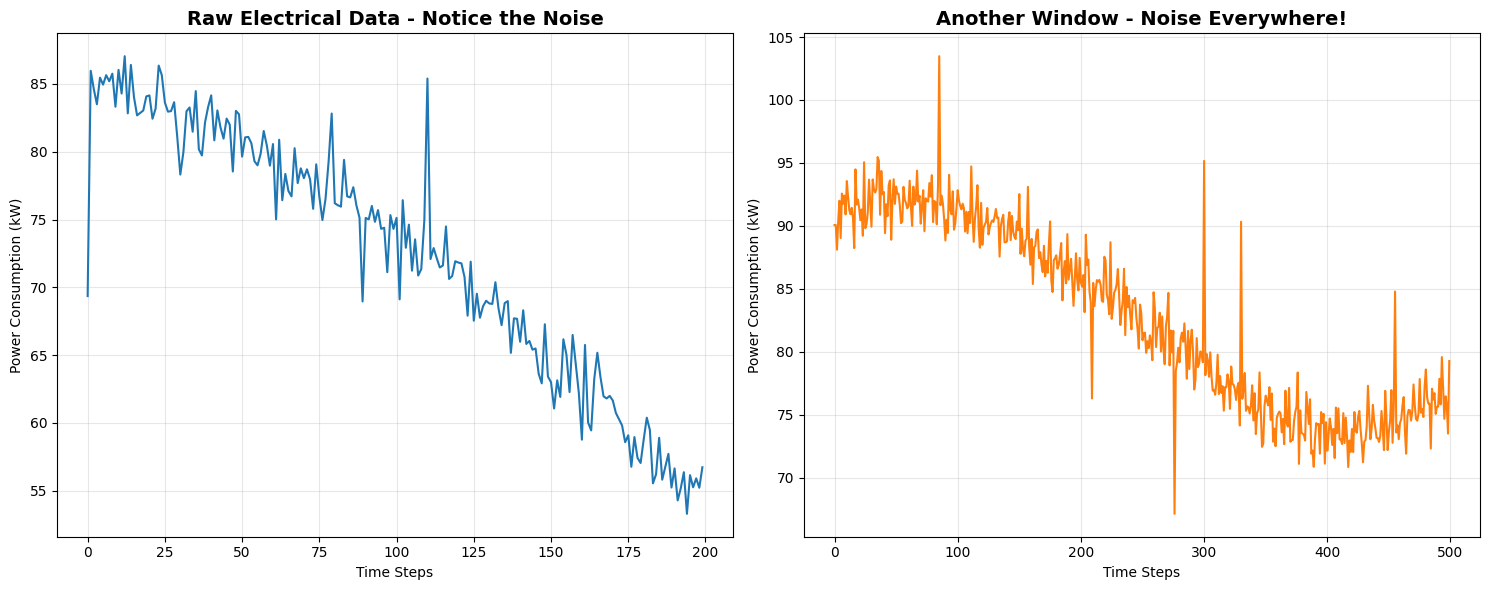

🚨 PROBLEM: This electrical transformer data has:
   • Sensor measurement noise
   • Electrical interference spikes
   • Random fluctuations

💡 GOAL: Train on noisy data (realistic), but clean inputs at inference (better predictions)


In [3]:
# Let's visualize our electrical data to see the noise problem
plt.figure(figsize=(15, 6))

# Show different time windows
plt.subplot(1, 2, 1)
plt.plot(electrical_data[1000:1200], linewidth=1.5, color='tab:blue')
plt.title("Raw Electrical Data - Notice the Noise", fontsize=14, fontweight='bold')
plt.xlabel("Time Steps")
plt.ylabel("Power Consumption (kW)")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(electrical_data[5000:5500], linewidth=1.5, color='tab:orange')
plt.title("Another Window - Noise Everywhere!", fontsize=14, fontweight='bold')
plt.xlabel("Time Steps") 
plt.ylabel("Power Consumption (kW)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🚨 PROBLEM: This electrical transformer data has:")
print("   • Sensor measurement noise")
print("   • Electrical interference spikes") 
print("   • Random fluctuations")
print("\n💡 GOAL: Train on noisy data (realistic), but clean inputs at inference (better predictions)")


## 1️⃣ Section 1: Standard Dataset Approach

This is what most PyTorch tutorials show you - and it works fine for clean data. Let's build a basic time series dataset that creates input/output windows for prediction.


In [4]:
class BasicTimeSeriesDataset(Dataset):
    """
    🔍 KEY PYTORCH CONCEPT: Custom Dataset
    
    Every PyTorch Dataset must inherit from torch.utils.data.Dataset and implement:
    1. __init__(): Initialize the dataset 
    2. __len__(): Return the number of samples
    3. __getitem__(): Return a single sample given an index
    
    This is the CONTRACT that PyTorch DataLoader expects!
    """
    
    def __init__(self, data: np.ndarray, window_size: int = 96, horizon: int = 24):
        """
        Args:
            data: 1D time series data
            window_size: Length of input sequence (e.g., 96 hours = 4 days)  
            horizon: Length of prediction target (e.g., 24 hours = 1 day ahead)
        """
        self.data = data
        self.window_size = window_size
        self.horizon = horizon
        
        print(f"📊 Dataset created with:")
        print(f"   • {len(data)} total time points")
        print(f"   • {window_size} time steps input window") 
        print(f"   • {horizon} time steps prediction horizon")
        print(f"   • {self.__len__()} total samples available")
    
    def __len__(self) -> int:
        """
        🔍 KEY PYTORCH CONCEPT: Dataset Length
        
        DataLoader uses this to know how many samples exist.
        We need enough data points for: [input_window] + [prediction_target]
        """
        return len(self.data) - self.window_size - self.horizon + 1
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        🔍 KEY PYTORCH CONCEPT: Sample Retrieval
        
        DataLoader calls this method to get individual samples.
        It automatically handles batching, shuffling, etc.
        
        Returns:
            input_window: Historical data for prediction 
            target: Future values to predict
        """
        # Extract input window: data[idx : idx + window_size]
        input_window = self.data[idx:idx + self.window_size]
        
        # Extract target window: data[idx + window_size : idx + window_size + horizon]  
        target = self.data[idx + self.window_size:idx + self.window_size + self.horizon]
        
        # 🔍 IMPORTANT: Convert to PyTorch tensors!
        # DataLoader expects tensors, not numpy arrays
        return torch.FloatTensor(input_window), torch.FloatTensor(target)

# Create the standard dataset
print("🏗️ Creating BasicTimeSeriesDataset...")
standard_dataset = BasicTimeSeriesDataset(electrical_data, window_size=96, horizon=24)


🏗️ Creating BasicTimeSeriesDataset...
📊 Dataset created with:
   • 10000 total time points
   • 96 time steps input window
   • 24 time steps prediction horizon
   • 9881 total samples available


In [5]:
# 🔍 KEY PYTORCH CONCEPT: DataLoader
# DataLoader wraps your Dataset and provides:
# • Automatic batching (groups samples together)
# • Shuffling (randomizes order for training)
# • Parallel loading (speeds up data loading)
# • Memory management (loads data as needed)

print("🚀 Creating DataLoader...")
standard_loader = DataLoader(
    standard_dataset,           # Our custom dataset
    batch_size=32,             # Group 32 samples per batch
    shuffle=True,              # Randomize order (good for training)
    num_workers=0,             # Number of parallel processes (0 = single thread)
    pin_memory=False           # Speed optimization for GPU (if available)
)

print(f"DataLoader created with {len(standard_loader)} batches")

# Let's see what we get from the DataLoader
print("\n🔍 Inspecting first batch...")
for batch_idx, (batch_x, batch_y) in enumerate(standard_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Input shape: {batch_x.shape}")    # [batch_size, window_size] = [32, 96]
    print(f"  Target shape: {batch_y.shape}")   # [batch_size, horizon] = [32, 24]
    print(f"  Input data type: {batch_x.dtype}")
    print(f"  Target data type: {batch_y.dtype}")
    
    # Show first sample in the batch
    print(f"\n  First sample input range: [{batch_x[0].min():.2f}, {batch_x[0].max():.2f}]")
    print(f"  First sample target range: [{batch_y[0].min():.2f}, {batch_y[0].max():.2f}]")
    
    break  # Only show first batch

print(f"\n✅ Standard approach works! We get batches of {batch_x.shape[0]} samples,")
print(f"   each with {batch_x.shape[1]} input time steps and {batch_y.shape[1]} target time steps.")


🚀 Creating DataLoader...
DataLoader created with 309 batches

🔍 Inspecting first batch...
Batch 1:
  Input shape: torch.Size([32, 96])
  Target shape: torch.Size([32, 24])
  Input data type: torch.float32
  Target data type: torch.float32

  First sample input range: [73.81, 83.35]
  First sample target range: [62.90, 76.81]

✅ Standard approach works! We get batches of 32 samples,
   each with 96 input time steps and 24 target time steps.


## 2️⃣ Section 2: The Problem with Noisy Data

The standard approach works, but look at this noisy electrical data. During training, we **want** the model to learn from this realistic noisy data so it's robust to real-world conditions. 

But at inference time - when we're making actual predictions - what if we could clean the input to get better results?

**That's where custom datasets become powerful: Same training data, but preprocessing for inference.**


/var/folders/df/nf3r4lm93rbf2zr46sdq3mkc0000gp/T/ipykernel_1758/3166569792.py:60: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/df/nf3r4lm93rbf2zr46sdq3mkc0000gp/T/ipykernel_1758/3166569792.py:60: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/df/nf3r4lm93rbf2zr46sdq3mkc0000gp/T/ipykernel_1758/3166569792.py:60: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/df/nf3r4lm93rbf2zr46sdq3mkc0000gp/T/ipykernel_1758/3166569792.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/df/nf3r4lm93rbf2zr46sdq3mkc0000gp/T/ipykernel_1758/3166569792.py:60: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/chris/repos/deep-learning/.venv/lib/python3.12/site-packag

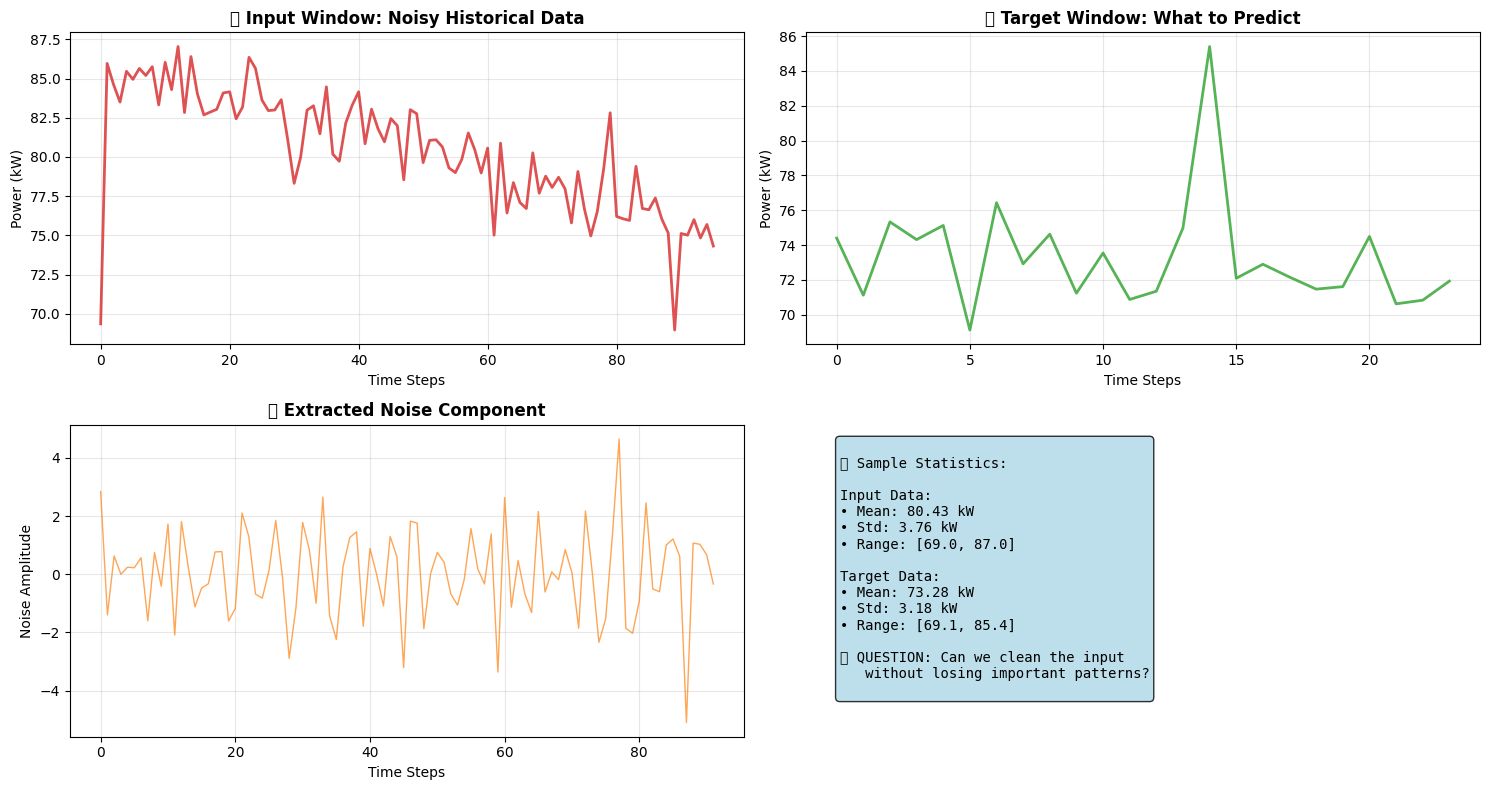

🎯 KEY INSIGHT: The noise makes it harder for models to learn the underlying patterns!
💡 SOLUTION: Train on noisy data (robustness) + Clean data at inference (accuracy)


In [6]:
# Let's examine a specific noisy sample to understand the problem
sample_idx = 1000
input_sample, target_sample = standard_dataset[sample_idx]

plt.figure(figsize=(15, 8))

# Plot 1: Input window (what model sees)
plt.subplot(2, 2, 1)
plt.plot(input_sample.numpy(), linewidth=2, color='tab:red', alpha=0.8)
plt.title("🔴 Input Window: Noisy Historical Data", fontsize=12, fontweight='bold')
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.grid(True, alpha=0.3)

# Plot 2: Target window (what model should predict)
plt.subplot(2, 2, 2)
plt.plot(target_sample.numpy(), linewidth=2, color='tab:green', alpha=0.8)
plt.title("🟢 Target Window: What to Predict", fontsize=12, fontweight='bold')
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.grid(True, alpha=0.3)

# Plot 3: Noise analysis
plt.subplot(2, 2, 3)
# Compute simple moving average to see underlying trend
input_np = input_sample.numpy()
window = 5
smooth = np.convolve(input_np, np.ones(window)/window, mode='valid')
noise = input_np[window//2:-window//2+1] - smooth

plt.plot(noise, linewidth=1, color='tab:orange', alpha=0.7)
plt.title("🟠 Extracted Noise Component", fontsize=12, fontweight='bold')
plt.xlabel("Time Steps")
plt.ylabel("Noise Amplitude")
plt.grid(True, alpha=0.3)

# Plot 4: Statistics
plt.subplot(2, 2, 4)
stats_text = f"""
📊 Sample Statistics:

Input Data:
• Mean: {input_sample.mean():.2f} kW
• Std: {input_sample.std():.2f} kW
• Range: [{input_sample.min():.1f}, {input_sample.max():.1f}]

Target Data:
• Mean: {target_sample.mean():.2f} kW  
• Std: {target_sample.std():.2f} kW
• Range: [{target_sample.min():.1f}, {target_sample.max():.1f}]

🤔 QUESTION: Can we clean the input
   without losing important patterns?
"""
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
plt.axis('off')

plt.tight_layout()
plt.show()

print("🎯 KEY INSIGHT: The noise makes it harder for models to learn the underlying patterns!")
print("💡 SOLUTION: Train on noisy data (robustness) + Clean data at inference (accuracy)")


## 3️⃣ Section 3: Custom Dataset with Conditional Denoising

Now here's where PyTorch's flexibility shines! We'll build a dataset that can **optionally** denoise the data. 

- **Training mode**: `denoise=False` → Model learns from noisy, realistic data
- **Inference mode**: `denoise=True` → Model gets cleaner inputs for better predictions

**Key insight**: Same dataset class, different behavior controlled by a simple flag!


In [7]:
class InferenceTimeSeriesDataset(Dataset):
    """
    🚀 ADVANCED PYTORCH CONCEPT: Conditional Dataset Processing
    
    This dataset can behave differently based on a flag:
    • Training: Uses raw noisy data (denoise=False)
    • Inference: Applies Fourier denoising (denoise=True)
    
    Same PyTorch Dataset interface, but with conditional preprocessing!
    """
    
    def __init__(self, data: np.ndarray, window_size: int = 96, horizon: int = 24, 
                 denoise: bool = False, keep_top_k: int = 20):
        """
        Args:
            data: 1D time series data
            window_size: Length of input sequence
            horizon: Length of prediction target
            denoise: Whether to apply Fourier denoising (KEY PARAMETER!)
            keep_top_k: Number of strongest frequency components to keep
        """
        self.data = data
        self.window_size = window_size
        self.horizon = horizon
        self.denoise = denoise  # 🔑 This controls the behavior!
        self.keep_top_k = keep_top_k
        
        mode = "🧹 INFERENCE (Denoised)" if denoise else "🏋️ TRAINING (Noisy)"
        print(f"📊 InferenceTimeSeriesDataset created in {mode} mode:")
        print(f"   • {len(data)} total time points")
        print(f"   • {window_size} time steps input window") 
        print(f"   • {horizon} time steps prediction horizon")
        print(f"   • Denoising: {'ON' if denoise else 'OFF'}")
        if denoise:
            print(f"   • Keeping top {keep_top_k} frequency components")
        print(f"   • {self.__len__()} total samples available")
    
    def fourier_denoise(self, signal: np.ndarray) -> np.ndarray:
        """
        🔧 DENOISING TECHNIQUE: Fourier Frequency Filtering
        
        How it works:
        1. Transform signal to frequency domain (FFT)
        2. Identify strongest frequency components  
        3. Zero out weak/noisy frequencies
        4. Transform back to time domain (IFFT)
        
        This preserves main patterns while removing high-frequency noise!
        """
        # Step 1: Transform to frequency domain
        fft = np.fft.fft(signal)
        
        # Step 2: Find strongest frequency components
        magnitude = np.abs(fft)
        top_k_indices = np.argsort(magnitude)[-self.keep_top_k:]
        
        # Step 3: Zero out weak frequencies (noise reduction)
        fft_filtered = np.zeros_like(fft)
        fft_filtered[top_k_indices] = fft[top_k_indices]
        
        # Step 4: Convert back to time domain
        denoised_signal = np.fft.ifft(fft_filtered).real
        
        return denoised_signal.astype(np.float32)
    
    def __len__(self) -> int:
        """Same length calculation as basic dataset"""
        return len(self.data) - self.window_size - self.horizon + 1
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        🔍 KEY PYTORCH CONCEPT: Conditional Data Processing
        
        This is where the magic happens! The same __getitem__ method can:
        • Return raw noisy data (training mode)
        • Return denoised data (inference mode)
        
        PyTorch DataLoader doesn't care - it just calls this method!
        """
        # Get raw data windows (same as before)
        raw_window = self.data[idx:idx + self.window_size]
        target = self.data[idx + self.window_size:idx + self.window_size + self.horizon]
        
        # 🔄 CONDITIONAL PROCESSING: Apply denoising only if requested
        if self.denoise:
            # Inference mode: clean the input for better predictions
            processed_window = self.fourier_denoise(raw_window)
        else:
            # Training mode: use raw noisy data for robustness  
            processed_window = raw_window
        
        # Convert to PyTorch tensors
        return torch.FloatTensor(processed_window), torch.FloatTensor(target)

print("🏗️ Custom dataset class defined! Let's test it...")


🏗️ Custom dataset class defined! Let's test it...


## 4️⃣ Section 4: Side-by-Side Comparison

Let's create both training and inference datasets using the same data, then see the dramatic difference between noisy and denoised inputs!


In [8]:
# Create both datasets with same data but different modes
print("🏗️ Creating training dataset (noisy data)...")
training_dataset = InferenceTimeSeriesDataset(electrical_data, denoise=False)

print("\n🏗️ Creating inference dataset (denoised data)...")  
inference_dataset = InferenceTimeSeriesDataset(electrical_data, denoise=True, keep_top_k=20)

print("\n✅ Both datasets created! Same underlying data, different preprocessing.")


🏗️ Creating training dataset (noisy data)...
📊 InferenceTimeSeriesDataset created in 🏋️ TRAINING (Noisy) mode:
   • 10000 total time points
   • 96 time steps input window
   • 24 time steps prediction horizon
   • Denoising: OFF
   • 9881 total samples available

🏗️ Creating inference dataset (denoised data)...
📊 InferenceTimeSeriesDataset created in 🧹 INFERENCE (Denoised) mode:
   • 10000 total time points
   • 96 time steps input window
   • 24 time steps prediction horizon
   • Denoising: ON
   • Keeping top 20 frequency components
   • 9881 total samples available

✅ Both datasets created! Same underlying data, different preprocessing.


🔍 Comparing sample 1000 from both datasets...
Raw sample shape: torch.Size([96])
Clean sample shape: torch.Size([96])


AttributeError: 'numpy.ndarray' object has no attribute 'text'

/Users/chris/repos/deep-learning/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/chris/repos/deep-learning/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 127947 (\N{WEIGHT LIFTER}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/chris/repos/deep-learning/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


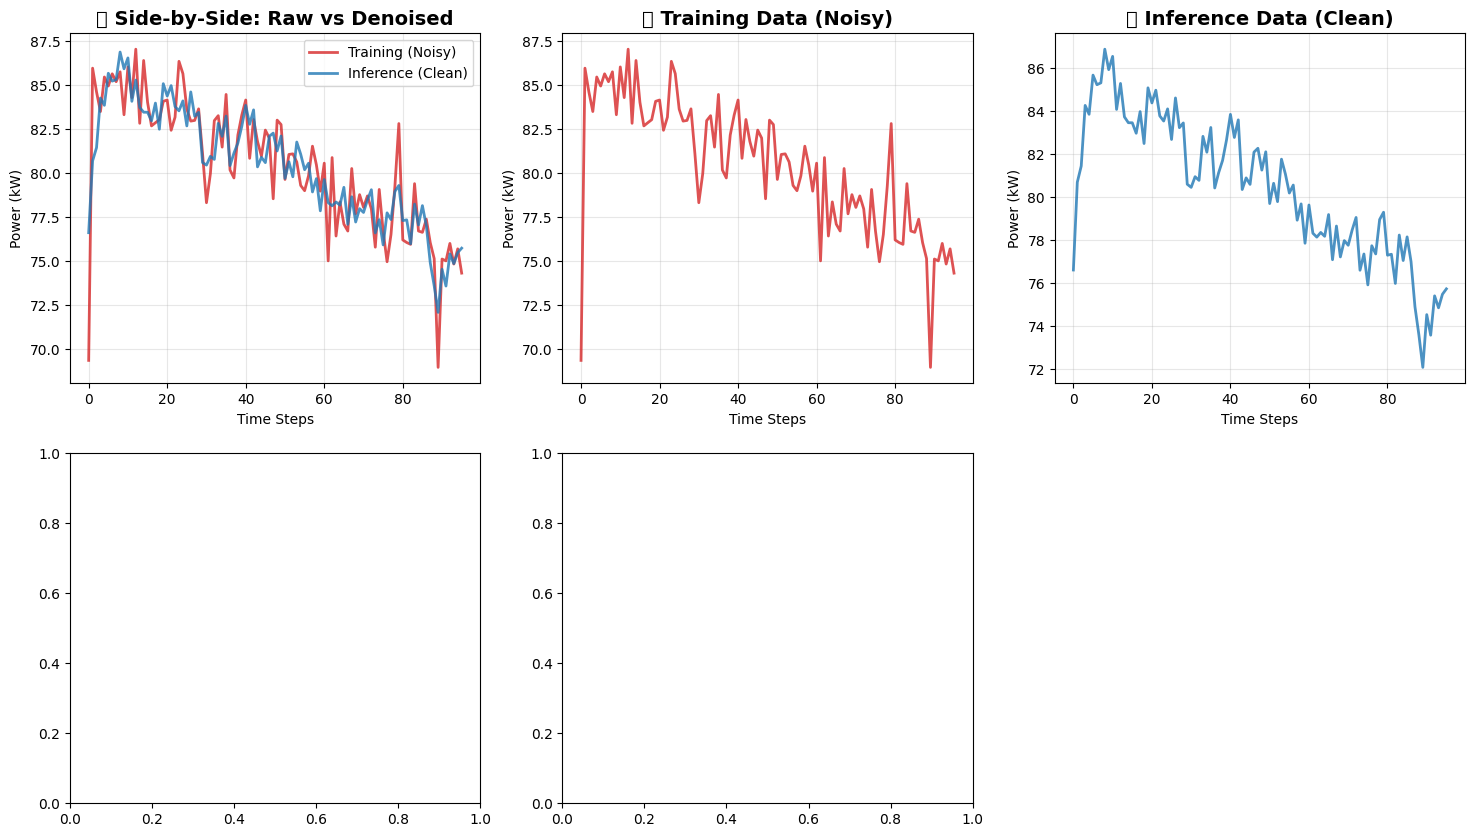

In [ ]:
Compare the same sample from both datasets
sample_idx = 1000

print(f"🔍 Comparing sample {sample_idx} from both datasets...")

# Get the same sample from both datasets
raw_sample, raw_target = training_dataset[sample_idx]     # Noisy version
clean_sample, clean_target = inference_dataset[sample_idx] # Denoised version

print(f"Raw sample shape: {raw_sample.shape}")
print(f"Clean sample shape: {clean_sample.shape}")

# Visualize the dramatic difference
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Full comparison
axes[0, 0].plot(raw_sample.numpy(), linewidth=2, color='tab:red', alpha=0.8, label='Training (Noisy)')
axes[0, 0].plot(clean_sample.numpy(), linewidth=2, color='tab:blue', alpha=0.8, label='Inference (Clean)')
axes[0, 0].set_title("🔄 Side-by-Side: Raw vs Denoised", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Time Steps")
axes[0, 0].set_ylabel("Power (kW)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Row 1: Training data only
axes[0, 1].plot(raw_sample.numpy(), linewidth=2, color='tab:red', alpha=0.8)
axes[0, 1].set_title("🏋️ Training Data (Noisy)", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Time Steps")
axes[0, 1].set_ylabel("Power (kW)")
axes[0, 1].grid(True, alpha=0.3)

# Row 1: Inference data only  
axes[0, 2].plot(clean_sample.numpy(), linewidth=2, color='tab:blue', alpha=0.8)
axes[0, 2].set_title("🧹 Inference Data (Clean)", fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel("Time Steps")
axes[0, 2].set_ylabel("Power (kW)")
axes[0, 2].grid(True, alpha=0.3)

# Statistics comparison
axes[1, 2].axis('off')
stats_text = f"""
📊 COMPARISON STATISTICS:

Training Data (Noisy):
• Mean: {raw_sample.mean():.2f} kW
• Std: {raw_sample.std():.2f} kW
• Range: [{raw_sample.min():.1f}, {raw_sample.max():.1f}]

Inference Data (Clean):
• Mean: {clean_sample.mean():.2f} kW
• Std: {clean_sample.std():.2f} kW  
• Range: [{clean_sample.min():.1f}, {clean_sample.max():.1f}]


🎯 Result: Same underlying pattern,
   much less noise!
"""

axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.show()

print("🎯 KEY INSIGHT: Same underlying signal, but the inference version is much cleaner!")
print("💡 The model trains on realistic noisy data but gets cleaner inputs for predictions.")


## 5️⃣ Section 5: DataLoader Integration & Complete Workflow

Now let's see how this works in a complete ML pipeline. The beauty is that **your training loop doesn't change** - you just swap the dataset!


In [13]:
# Split data for training and testing
train_size = int(0.8 * len(electrical_data))
train_data = electrical_data[:train_size]
test_data = electrical_data[train_size:]

print(f"📊 Data split:")
print(f"   • Training data: {len(train_data)} time points")
print(f"   • Test data: {len(test_data)} time points")

# ========================================
# 🏋️ TRAINING PHASE - Use noisy data
# ========================================
print("\n" + "="*50)
print("🏋️ TRAINING PHASE")
print("="*50)

# Create training dataset with noisy data (denoise=False)
model_training_dataset = InferenceTimeSeriesDataset(
    train_data, 
    window_size=96, 
    horizon=24,
    denoise=False  # 🔑 Training on noisy, realistic data
)

# Create training DataLoader
training_loader = DataLoader(
    model_training_dataset,
    batch_size=32,
    shuffle=True,      # Randomize for training
    num_workers=0,     
    pin_memory=False
)

print(f"\n🚀 Training DataLoader created with {len(training_loader)} batches")

# Simulate training loop (just show the data flow)
print("\n🔄 Training loop simulation...")
for batch_idx, (batch_x, batch_y) in enumerate(training_loader):
    print(f"Training Batch {batch_idx + 1}:")
    print(f"  📥 Input: {batch_x.shape} | Mean: {batch_x.mean():.2f} | Std: {batch_x.std():.2f}")
    print(f"  🎯 Target: {batch_y.shape} | Mean: {batch_y.mean():.2f} | Std: {batch_y.std():.2f}")
    
    # This is where you would do:
    # model.train()
    # optimizer.zero_grad()
    # predictions = model(batch_x)
    # loss = criterion(predictions, batch_y)
    # loss.backward()
    # optimizer.step()
    
    if batch_idx >= 2:  # Just show first 3 batches
        print("   ... (continuing training on noisy data)")
        break

print("\n✅ Training phase: Model learns from realistic noisy data → Robust to real-world conditions")


📊 Data split:
   • Training data: 8000 time points
   • Test data: 2000 time points

🏋️ TRAINING PHASE
📊 InferenceTimeSeriesDataset created in 🏋️ TRAINING (Noisy) mode:
   • 8000 total time points
   • 96 time steps input window
   • 24 time steps prediction horizon
   • Denoising: OFF
   • 7881 total samples available

🚀 Training DataLoader created with 247 batches

🔄 Training loop simulation...
Training Batch 1:
  📥 Input: torch.Size([32, 96]) | Mean: 64.85 | Std: 21.56
  🎯 Target: torch.Size([32, 24]) | Mean: 64.40 | Std: 21.38
Training Batch 2:
  📥 Input: torch.Size([32, 96]) | Mean: 64.42 | Std: 20.67
  🎯 Target: torch.Size([32, 24]) | Mean: 63.51 | Std: 21.53
Training Batch 3:
  📥 Input: torch.Size([32, 96]) | Mean: 60.10 | Std: 23.88
  🎯 Target: torch.Size([32, 24]) | Mean: 59.47 | Std: 24.20
   ... (continuing training on noisy data)

✅ Training phase: Model learns from realistic noisy data → Robust to real-world conditions


In [14]:
# ========================================
# 🧹 INFERENCE PHASE - Use denoised data  
# ========================================
print("\n" + "="*50)
print("🧹 INFERENCE PHASE")
print("="*50)

# Create inference dataset with denoised data (denoise=True)
model_inference_dataset = InferenceTimeSeriesDataset(
    test_data,
    window_size=96,
    horizon=24, 
    denoise=True,      # 🔑 Clean inputs for better predictions
    keep_top_k=20      # Keep top 20 frequency components
)

# Create inference DataLoader  
inference_loader = DataLoader(
    model_inference_dataset,
    batch_size=32,
    shuffle=False,     # Don't shuffle for inference
    num_workers=0,
    pin_memory=False
)

print(f"\n🚀 Inference DataLoader created with {len(inference_loader)} batches")

# Simulate inference loop (just show the data flow)
print("\n🔄 Inference loop simulation...")
for batch_idx, (batch_x, batch_y) in enumerate(inference_loader):
    print(f"Inference Batch {batch_idx + 1}:")
    print(f"  📥 Input: {batch_x.shape} | Mean: {batch_x.mean():.2f} | Std: {batch_x.std():.2f}")
    print(f"  🎯 Target: {batch_y.shape} | Mean: {batch_y.mean():.2f} | Std: {batch_y.std():.2f}")
    
    # This is where you would do:
    # model.eval()
    # with torch.no_grad():
    #     predictions = model(batch_x)
    #     # predictions are likely more accurate due to cleaner inputs!
    
    if batch_idx >= 2:  # Just show first 3 batches
        print("   ... (continuing inference with clean data)")
        break

print("\n✅ Inference phase: Model gets cleaner inputs → Better predictions!")

# ========================================
# 📊 COMPARISON SUMMARY
# ========================================
print("\n" + "="*60)
print("📊 COMPARISON SUMMARY")
print("="*60)

# Compare noise levels between training and inference
training_sample, _ = model_training_dataset[100]  # Noisy
inference_sample, _ = model_inference_dataset[100]  # Clean

noise_reduction = ((training_sample.std() - inference_sample.std()) / training_sample.std()) * 100

print(f"""
🏋️ TRAINING MODE (denoise=False):
   • Uses noisy, realistic data
   • Model learns robustness
   • Sample std: {training_sample.std():.3f}

🧹 INFERENCE MODE (denoise=True):  
   • Uses Fourier-denoised data
   • Cleaner inputs for predictions
   • Sample std: {inference_sample.std():.3f}
   
📉 NOISE REDUCTION: {noise_reduction:.1f}%

🎯 RESULT: Same PyTorch workflow, dramatically different data quality!
""")

print("💡 KEY INSIGHT: Your training loop stays exactly the same - just swap the dataset!")



🧹 INFERENCE PHASE
📊 InferenceTimeSeriesDataset created in 🧹 INFERENCE (Denoised) mode:
   • 2000 total time points
   • 96 time steps input window
   • 24 time steps prediction horizon
   • Denoising: ON
   • Keeping top 20 frequency components
   • 1881 total samples available

🚀 Inference DataLoader created with 59 batches

🔄 Inference loop simulation...
Inference Batch 1:
  📥 Input: torch.Size([32, 96]) | Mean: 82.84 | Std: 1.93
  🎯 Target: torch.Size([32, 24]) | Mean: 84.73 | Std: 1.80
Inference Batch 2:
  📥 Input: torch.Size([32, 96]) | Mean: 84.11 | Std: 1.42
  🎯 Target: torch.Size([32, 24]) | Mean: 84.92 | Std: 3.56
Inference Batch 3:
  📥 Input: torch.Size([32, 96]) | Mean: 84.64 | Std: 1.79
  🎯 Target: torch.Size([32, 24]) | Mean: 82.80 | Std: 2.78
   ... (continuing inference with clean data)

✅ Inference phase: Model gets cleaner inputs → Better predictions!

📊 COMPARISON SUMMARY

🏋️ TRAINING MODE (denoise=False):
   • Uses noisy, realistic data
   • Model learns robustness


## 🎯 Wrap-up & Key Takeaways

We've just built a **powerful, flexible PyTorch data loading system** that can adapt to different phases of your ML pipeline!

### 🔑 Key PyTorch Concepts Covered:

1. **Custom Dataset Classes**: Inherit from `torch.utils.data.Dataset` and implement `__init__`, `__len__`, and `__getitem__`
2. **DataLoader Integration**: Automatic batching, shuffling, and parallel loading
3. **Conditional Processing**: Same dataset class, different behavior controlled by flags
4. **Preprocessing Pipeline**: Transform data on-the-fly as it's loaded

### 💡 Key Insights:

- **Train on noisy data** → Model learns robustness to real-world conditions
- **Infer on clean data** → Better predictions without compromising training
- **Same PyTorch API** → No changes to your training/inference loops
- **Fourier denoising** → Preserve important patterns while removing noise

### 🚀 What's Next?

In the next notebook, we'll:
- Build an actual neural network for time series prediction
- Compare prediction accuracy with noisy vs denoised inputs
- Show quantitative improvements from this preprocessing strategy

**The power of custom datasets: Control exactly how your data gets preprocessed while keeping PyTorch's powerful abstractions!**
